# train a simple network

In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from utils import load_stuff
from model import test, run_episode, cal_loss
import torch as th
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
import plot as plot
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/Users/mahdiyar/miniconda3/envs/dl/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


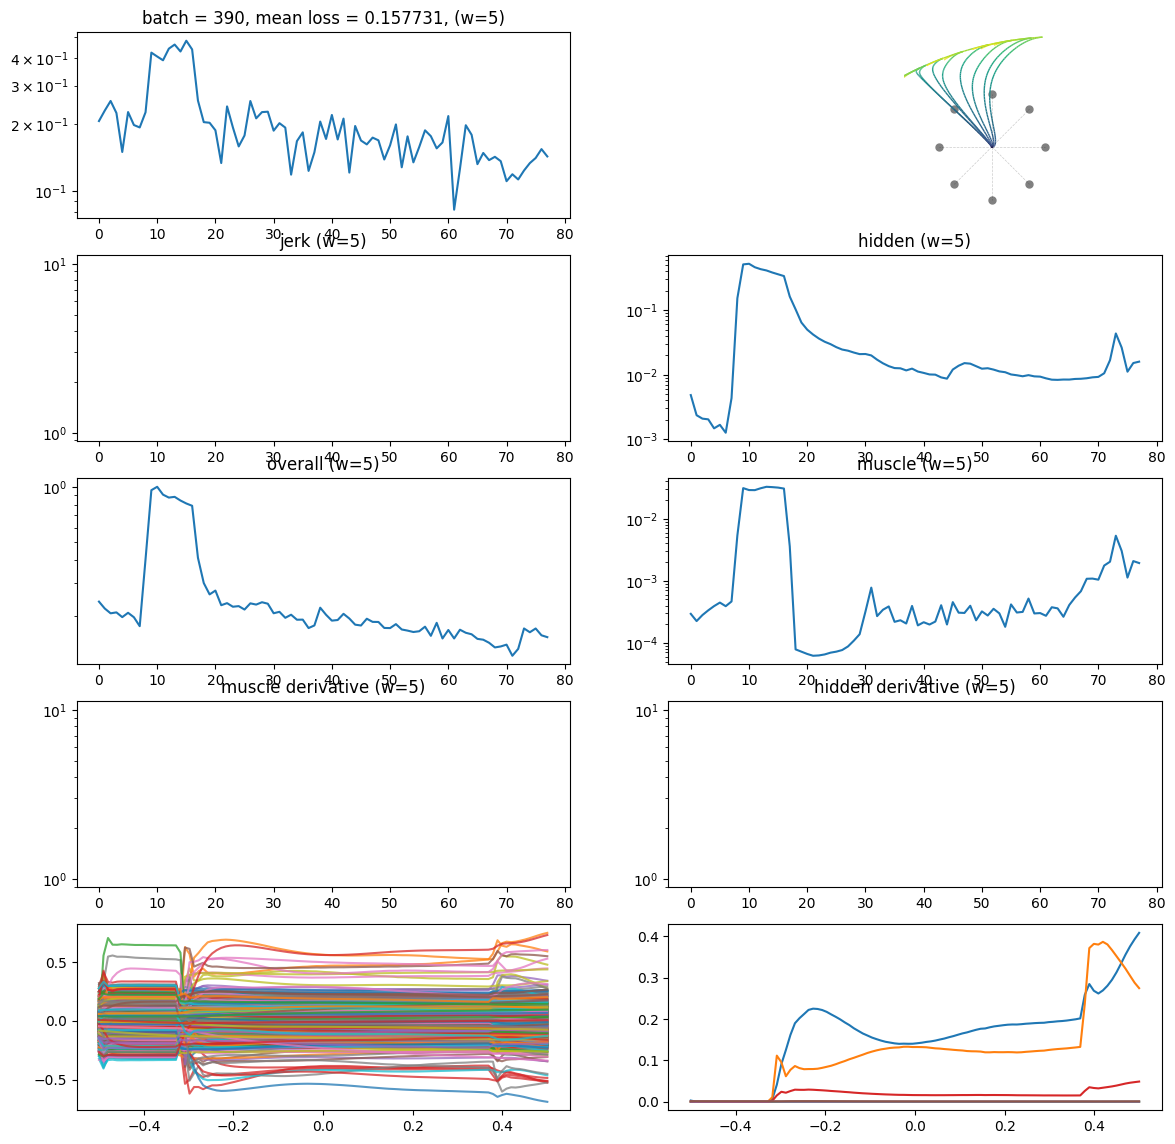

Training growing_up:  40%|███▉      | 399/1000 [07:12<10:51,  1.08s/batch]


KeyboardInterrupt: 

In [27]:
base_dir = os.path.join(os.path.expanduser('~'),'Documents','Data','MotorNet')
n_hidden = 1024

directory_name = 'fine_tuning'
model_name = f'model_{n_hidden}'
n_batch = 1000


phase = 'growing_up'
ff_coefficient = 0
interval = 10


loss_weight = np.array([1e0,0,1e-5,0,1e0,0,0])



#loss_weight = np.array([1e+3,1e+2,1e-0,3e-4,1e-2,1e-3,0])

# 'position', 'jerk', 'muscle', 'muscle_derivative', 'hidden', 'hidden_derivative', 'hidden_jerk



catch_trial_perc = 50
if not os.path.exists(os.path.join(base_dir,directory_name)):
    os.makedirs(os.path.join(base_dir,directory_name))

output_folder = os.path.join(base_dir,directory_name)

losses = {
    'overall': [],
    'position': [],
    'jerk': [],
    'muscle': [],
    'muscle_derivative': [],
    'hidden': [],
    'hidden_derivative': [],
    'hidden_jerk': [],
    }
    

# load environment and policy
env, policy, optimizer, scheduler = load_stuff(None,None,n_hidden=n_hidden)

for batch in tqdm(range(n_batch), desc=f"Training {phase}", unit="batch"):

    # test the network right at the beginning
    data_test, loss_test, ang_dev, lat_dev = test(env,policy,ff_coefficient=ff_coefficient,loss_weight=loss_weight)
    
    data = run_episode(env,policy,32,catch_trial_perc,'train',ff_coefficient=ff_coefficient,detach=False)

    overall_loss, loss_weigthed = cal_loss(data, loss_weight=loss_weight)
    
    # update the network
    optimizer.zero_grad()
    overall_loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)
    optimizer.step()

    if scheduler is not None:
      scheduler.step()

    # Save losses
    losses['overall'].append(overall_loss.item())

    for loss_type in loss_weigthed:
      if loss_type == 'position':
        pos=[]
        for j in range(8):
            pos_j = loss_weigthed[loss_type][j].item()
            pos.append(pos_j)
        losses[loss_type].append(pos)
      else:
        losses[loss_type].append(loss_weigthed[loss_type].item())


    # print progress
    if (batch % interval == 0) and (batch != 0):
        fg, ax = plt.subplots(nrows=5,ncols=2)
        clear_output(wait=True)
        fg.set_figwidth(14)
        fg.set_figheight(14)

        mean_loss = np.mean(sum(np.array(losses['position'])[-interval:,:])/interval)

        plot.plot_learning_curve(ax[0,0],losses,loss_type='position', w=5)
        ax[0,0].set_title(f'batch = {batch}, mean loss = {mean_loss:02f}, (w={5})')

        plot.plot_simulations(ax[0,1],xy=data_test['xy'],target_xy=data_test['tg'],vel=None,plot_lat=False,s=25)

        plot.plot_learning_curve(ax[1,0],losses,loss_type='jerk', w=5)
        ax[1,0].set_title("jerk (w=5)")
        
        plot.plot_learning_curve(ax[1,1],losses,loss_type='hidden', w=5)
        ax[1,1].set_title("hidden (w=5)")

        plot.plot_learning_curve(ax[2,0],losses,loss_type='overall', w=5)
        ax[2,0].set_title("overall (w=5)")

        plot.plot_learning_curve(ax[2,1],losses,loss_type='muscle', w=5)
        ax[2,1].set_title("muscle (w=5)")

        plot.plot_learning_curve(ax[3,0],losses,loss_type='muscle_derivative', w=5)
        ax[3,0].set_title("muscle derivative (w=5)")

        plot.plot_learning_curve(ax[3,1],losses,loss_type='hidden_derivative', w=5)
        ax[3,1].set_title("hidden derivative (w=5)")


        target = 0
        hidden = np.array(data_test['all_hidden'][target,:,:])
        muscle = np.array(data_test['all_action'][target,:,:])
        dt = 0.01
        x = np.linspace(0, np.shape(hidden)[0]*dt, np.shape(hidden)[0])-0.5

        for i in range(hidden.shape[1]):
           ax[4,0].plot(x,hidden[:,i],alpha=0.75)   

        for i in range(muscle.shape[1]):
            ax[4,1].plot(x,muscle[:,i])



        all_axes = fg.get_axes()
        colorbar_ax = all_axes[-1].remove()
        plt.show()